In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/submission-file/Submission_template_UHI2025-v2.csv
/kaggle/input/uncorrupted-training-data/Training_data_uhi_index_2025-02-18.csv


In [15]:
pip install overpy

Note: you may need to restart the kernel to use updated packages.


Number of water bodies fetched: 229


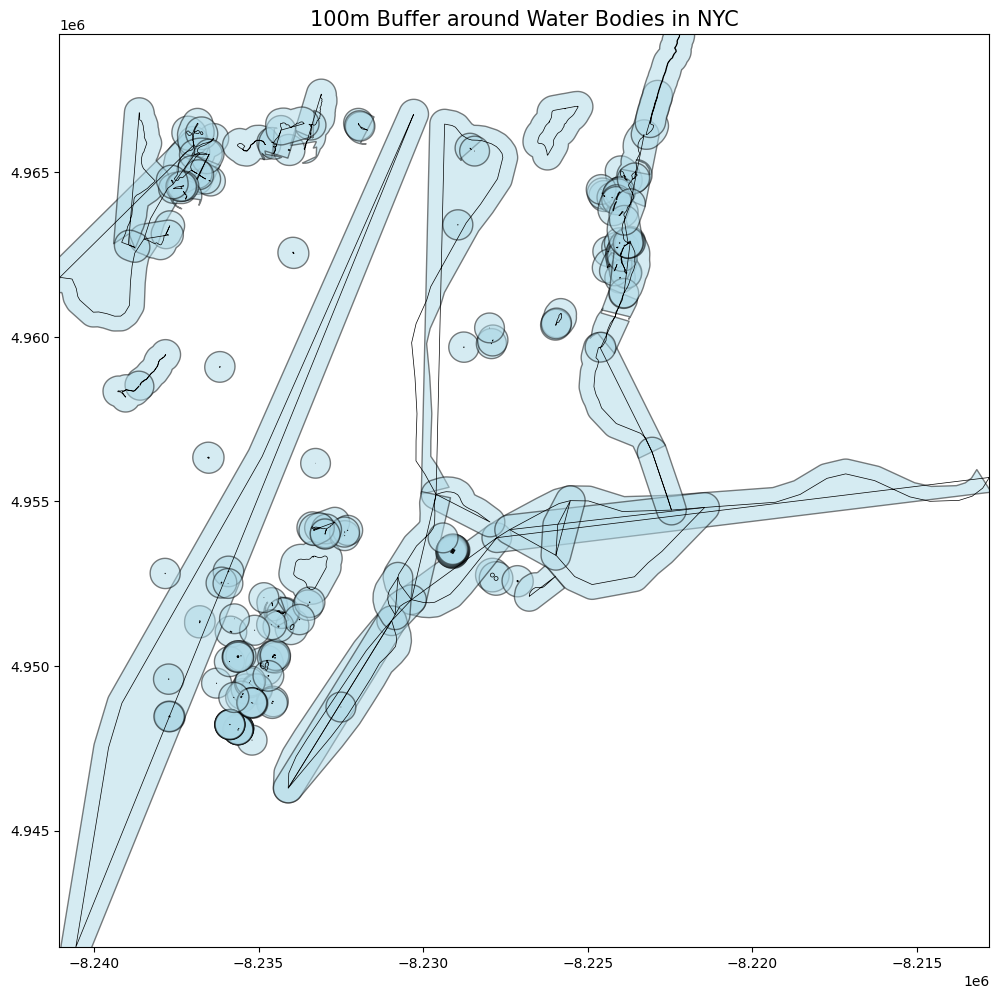

Successfully plotted 201 water bodies with 100m buffer


In [16]:
import overpy
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Set up the Overpass API client
api = overpy.Overpass()

# Define the bounding box (Lat, Lon)
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)

# Overpass query for water bodies
overpass_query = f"""
[out:json];
(
  way["natural"~"water"]({lower_left[0]},{lower_left[1]},{upper_right[0]},{upper_right[1]});
  way["waterway"~"river|stream|tidal_channel"]({lower_left[0]},{lower_left[1]},{upper_right[0]},{upper_right[1]});
);
out body;
(._;>;);
out skel qt;
"""
try:
    # Fetch the data from Overpass API
    result = api.query(overpass_query)

    print(f"Number of water bodies fetched: {len(result.ways)}")

    geometries, names = [], []

    for way in result.ways:
        try:
            nodes = [(float(node.lon), float(node.lat)) for node in way.nodes]
            if len(nodes) > 2:
                polygon = Polygon(nodes)
                geometries.append(polygon)
                names.append(way.tags.get('name', 'Unnamed'))
        except Exception as e:
            print(f"Error processing way {way.id}: {str(e)}")

    # Create a GeoDataFrame if geometries exist
    if geometries:
        gdf = gpd.GeoDataFrame({
            'name': names,
            'geometry': geometries
        }, crs="EPSG:4326")  # Specify the coordinate reference system

        # Reproject to a CRS with meters as units (EPSG:3395)
        gdf = gdf.to_crs(epsg=3395)

        # Create a 100-meter buffer around the water bodies
        gdf['buffer'] = gdf.geometry.buffer(450)

        # Create the plot
        fig, ax = plt.subplots(figsize=(12, 12))

        # Plot the buffered regions
        gdf['buffer'].plot(ax=ax, color="lightblue", alpha=0.5, edgecolor="black")

        # Add map context (optional)
        gdf.boundary.plot(ax=ax, color="black", linewidth=0.5)

        # Set plot limits to match bounding box
        ax.set_xlim(gdf.total_bounds[0], gdf.total_bounds[2])  # xmin, xmax
        ax.set_ylim(gdf.total_bounds[1], gdf.total_bounds[3])  # ymin, ymax

        ax.set_title("100m Buffer around Water Bodies in NYC", fontsize=15)
        ax.axis('on')  # Show axes to verify coordinates
        plt.show()

        print(f"Successfully plotted {len(gdf)} water bodies with 100m buffer")
    else:
        print("No valid water body geometries found to plot")

except overpy.exception.OverpassTooManyRequests:
    print("Too many requests to Overpass API. Please wait and try again.")
except Exception as e:
    print(f"An error occurred: {str(e)}")


In [17]:
train_df = pd.read_csv("/kaggle/input/uncorrupted-training-data/Training_data_uhi_index_2025-02-18.csv")

In [18]:
train_df

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,-73.909257,40.812845,24-07-2021 15:53,1.021634
...,...,...,...,...
11224,-73.957050,40.790333,24-07-2021 15:57,0.972470
11225,-73.957063,40.790308,24-07-2021 15:57,0.972470
11226,-73.957093,40.790270,24-07-2021 15:57,0.981124
11227,-73.957112,40.790253,24-07-2021 15:59,0.981245


In [19]:
from shapely.geometry import Point

# Convert the train_df into a GeoDataFrame
gdf_train = gpd.GeoDataFrame(train_df, 
                             geometry=[Point(lon, lat) for lon, lat in zip(train_df['Longitude'], train_df['Latitude'])], 
                             crs="EPSG:4326")

# Reproject the GeoDataFrame to match the CRS of the buffer regions (EPSG:3395)
gdf_train = gdf_train.to_crs(epsg=3395)

# Add a new column counting how many buffers contain the point
gdf_train['water'] = gdf_train.geometry.apply(
    lambda point: sum(gdf['buffer'].contains(point))
)

# Convert back to a regular DataFrame if you want
train_df['water'] = gdf_train['water']

# Check the results
print(train_df[['Latitude', 'Longitude', 'water']].head())

    Latitude  Longitude  water
0  40.813107 -73.909167      0
1  40.813045 -73.909187      0
2  40.812978 -73.909215      0
3  40.812908 -73.909242      0
4  40.812845 -73.909257      0


In [20]:
train_df['water'].describe()

count    11229.000000
mean         0.533173
std          1.204244
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          7.000000
Name: water, dtype: float64

In [21]:
train_df.to_csv('train_df_with_water.csv', index=False)

In [22]:
valid_df = pd.read_csv("/kaggle/input/submission-file/Submission_template_UHI2025-v2.csv")

In [23]:
valid_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,NaN
1,-73.971928,40.788875,NaN
2,-73.967080,40.789080,NaN
3,-73.972550,40.789082,NaN
4,-73.969697,40.787953,NaN
...,...,...,...
1035,-73.919388,40.813803,NaN
1036,-73.931033,40.833178,NaN
1037,-73.934647,40.854542,NaN
1038,-73.917223,40.815413,NaN


In [24]:
from shapely.geometry import Point

# Convert the valid_df into a GeoDataFrame
gdf_valid = gpd.GeoDataFrame(valid_df, 
                             geometry=[Point(lon, lat) for lon, lat in zip(valid_df['Longitude'], valid_df['Latitude'])], 
                             crs="EPSG:4326")

# Reproject the GeoDataFrame to match the CRS of the buffer regions (EPSG:3395)
gdf_valid = gdf_valid.to_crs(epsg=3395)

# Add a new column counting how many buffers contain the point
gdf_valid['water'] = gdf_valid.geometry.apply(
    lambda point: sum(gdf['buffer'].contains(point))
)

# Convert back to a regular DataFrame if you want
valid_df['water'] = gdf_valid['water']

# Check the results
print(valid_df[['Latitude', 'Longitude', 'water']].head())


    Latitude  Longitude  water
0  40.788763 -73.971665      0
1  40.788875 -73.971928      0
2  40.789080 -73.967080      1
3  40.789082 -73.972550      0
4  40.787953 -73.969697      1


In [25]:
valid_df['water'].describe()

count    1040.000000
mean        0.501923
std         1.191886
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: water, dtype: float64

In [26]:
valid_df.to_csv('valid_df_with_water.csv', index=False)